<a href="https://colab.research.google.com/github/andygoosh/wildfire.sberbank.ai/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [343]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%pylab inline
plt.style.use("bmh")

plt.rcParams["figure.figsize"] = (6,6)

import random as rn
import pandas as pd
import xarray
import requests
import datetime
import numpy as np
from tqdm import tqdm_notebook as tqdm
import sklearn as skl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

RS = 77
rn.seed(RS)
tf.random.set_seed(RS)
np.random.seed(RS)

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()

Populating the interactive namespace from numpy and matplotlib


## NCEP Dataset

Погодные данные из проекта [NCEP Reanalysis 2](https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis2.html) — усреднённые за день температура воздуха, относительная влажность и компоненты ветра. Данные можно получить с 1979 года.

Загрузите наборы данных в каталог `data/ncep/`:
- https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/air.2018.nc
- https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/uwnd.2018.nc
- https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/rhum.2018.nc

In [24]:
!pip3 install scipy

In [38]:
!pip3 install xarray

In [42]:
!pip3 install pydap

     |████████████████████████████████| 2.3MB 2.7MB/s 
     |████████████████████████████████| 122kB 49.5MB/s 


In [44]:
!wget https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/rhum.2018.nc
!wget https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/uwnd.2018.nc
!wget https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/air.2018.nc


--2019-11-21 12:07:34--  https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/rhum.2018.nc
Resolving www.esrl.noaa.gov (www.esrl.noaa.gov)... 140.172.253.69, 2610:20:8800:6001::45
Connecting to www.esrl.noaa.gov (www.esrl.noaa.gov)|140.172.253.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46055656 (44M) [application/x-netcdf]
Saving to: ‘rhum.2018.nc.1’

rhum.2018.nc.1      100%[===================>]  43.92M   503KB/s    in 2m 2s   

2019-11-21 12:09:36 (370 KB/s) - ‘rhum.2018.nc.1’ saved [46055656/46055656]

--2019-11-21 12:09:38--  https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/uwnd.2018.nc
Resolving www.esrl.noaa.gov (www.esrl.noaa.gov)... 140.172.253.69, 2610:20:8800:6001::45
Connecting to www.esrl.noaa.gov (www.esrl.noaa.gov)|140.172.253.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92099952 (88M) [application/x-netcdf]
Saving to: ‘uwnd.2018.nc’

uwnd.2018.nc        100%[===================>]  

In [277]:
ncep_data = []
year = 2018
for var in ('air', 'uwnd', 'rhum'):
    dataset_filename = '{}.{}.nc'.format(var, year)
    ncep_data.append(xarray.open_dataset(dataset_filename,),)
ncep_data = xarray.merge(ncep_data)

/usr/local/lib/python3.6/dist-packages/xarray/conventions.py:394: SerializationWarning: variable 'air' has multiple fill values {-99, 32767}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/usr/local/lib/python3.6/dist-packages/xarray/conventions.py:394: SerializationWarning: variable 'uwnd' has multiple fill values {-99, 32767}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/usr/local/lib/python3.6/dist-packages/xarray/conventions.py:394: SerializationWarning: variable 'rhum' has multiple fill values {-99, 32767}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)


## Набор признаков на основе данных NCEP

Ищем наиболее близкий к точке узел сетки в наборе NCEP, в качестве признаков значения переменных зарегистрированные в день регистрации точки и агрегированные показатели за период от 1 до 3х недель до момента регистрации точки.

In [0]:
def extract_features(row):
    point = ncep_data.sel(
        lon=row['longitude'],
        lat=row['latitude'],
        level=1000,
        method='nearest',
    )

    p1w = point.rolling(time=7).mean()
    p2w = point.rolling(time=14).mean()
    p3w = point.rolling(time=21).mean()
    
    date = row['date']
    v = point.sel(time=date)
    v1w = p1w.sel(time=date)
    v2w = p2w.sel(time=date)
    v3w = p3w.sel(time=date)
    
    return {
        'fire_id': row['fire_id'],
        'fire_type': row['fire_type'],
        'fire_type_name': row['fire_type_name'],
        'date': row['date'], 
        'temperature': v.air.values.item(0),
        'humidity': v.rhum.values.item(0),
        'uwind': v.uwnd.values.item(0),
        't1w': v1w.air.values.item(0),
        't2w': v2w.air.values.item(0),
        't3w': v3w.air.values.item(0),
        'h1w': v1w.rhum.values.item(0),
        'h2w': v2w.rhum.values.item(0),
        'h3w': v3w.rhum.values.item(0)
    }

## Выборка для обучения

In [50]:
df_train = pandas.read_csv('wildfires_train.csv')
df_subsample = df_train.query('(date > "2018") & (date < "2019")').sample(n=2000)

df_features = []
for i, row in tqdm(df_subsample.iterrows(), total=df_subsample.shape[0]):
    features = extract_features(row)
    df_features.append(features)
df_features = pandas.DataFrame(df_features)
df_features.set_index('fire_id', inplace=True)

df_features.to_csv('fts_preprocessed.cvs')

## Уменьшаем размерность фичей

In [3]:
pd.Series(pca.explained_variance_, index=t.columns).plot.bar()

NameError: ignored

fire_type
1      15
2       4
3      70
4     129
5      22
6     407
8     196
9     459
10    460
11    238
Name: fire_type, dtype: int64

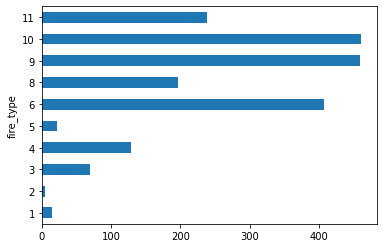

In [283]:
e = y.groupby(y).count()
e.plot.barh()
e

In [312]:
y_pred

array([ 8, 11, 10, ...,  8,  5,  3])

In [0]:
X, y = prepare_data(one_hotted=False)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


DecisionTreeClassifier: CV ROC AUC=0.597
DecisionTreeClassifier: CV ROC AUC=0.597


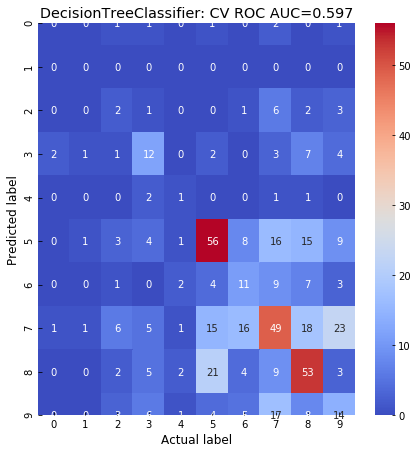

In [355]:
import sklearn.ensemble

#model = skl.ensemble.GradientBoostingClassifier()
#model = skl.linear_model.LogisticRegression()
model = sklearn.tree.DecisionTreeClassifier()
#model = skl.ensemble.RandomForestClassifier()

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=RS)

model.fit(X_train, y_train)

y_pred = model.predict_proba(X_cv)

df_predictions = pd.DataFrame(
    y_pred,
    index=y_cv.index,
    columns=[
        'fire_{}_prob'.format(class_id)
        for class_id in model.classes_
    ],
)

'''
GradientBoostingClassifier: CV ROC AUC=0.672
RandomForestClassifier: CV ROC AUC=0.673
LogisticRegression: CV ROC AUC=0.653
DecisionTreeClassifier: CV ROC AUC=0.590
'''
y_hotted = get_one_hot( y_cv )

draw_confusion_matrix(df_predictions, y_hotted)

In [0]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

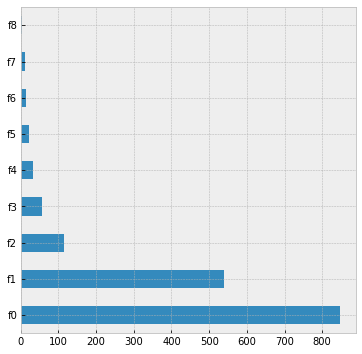

In [215]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)
t = pca.transform(X)

cols = [f"f{i:d}" for i in range(t.shape[1])]
X = pd.DataFrame(t, index=X.index, columns=cols)

feat_importances = pd.Series(pca.explained_variance_, index=X.columns)
feat_importances.plot(kind='barh')

## Прогнозирование на новых данных

DecisionTreeClassifier: CV ROC AUC=0.595


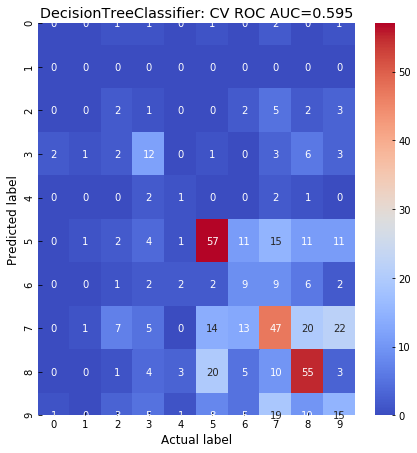

In [354]:
def draw_confusion_matrix( pred, gt):
  # get rid of probability, set max prob to 1, erst to 0
  pred_max_prob = pred.apply(lambda row: row.map(lambda e: 1 if e == row.max() else 0), axis = 1)
  # do the trick
  cnf_matrix = skl.metrics.confusion_matrix(pred_max_prob.values.argmax(axis=1), gt.values.argmax(axis=1))
  class_names=pred.columns
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="coolwarm" ,fmt='g')
  ax.xaxis.set_label_position("bottom")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1)
  plt.ylabel('Predicted label')
  plt.xlabel('Actual label')

  auc = skl.metrics.roc_auc_score(gt, pred)
  str = '{}: CV ROC AUC={:.3f}'.format(type(model).__name__, auc )
  plt.title(str, y=1)
  print(str)

draw_confusion_matrix(df_predictions, y_hotted)

In [0]:
def prepare_data(one_hotted=False):

  df_features = pd.read_csv('fts_preprocessed.cvs', index_col='fire_id')
  FTS = df_features.columns[3:]
  TARGET = 'fire_type'

  columns = [TARGET]

  X = df_features[FTS].fillna(0)
  if one_hotted == True:
    y = get_one_hot( df_features[TARGET] )
  else:
    y = df_features[TARGET]

  return X, y


In [297]:
y.head()

,fire_1_prob,fire_2_prob,fire_3_prob,fire_4_prob,fire_5_prob,fire_6_prob,fire_8_prob,fire_9_prob,fire_10_prob,fire_11_prob
fire_id,,,,,,,,,,
142462,0,0,0,0,0,1,0,0,0,0
146858,0,0,0,0,0,0,0,0,0,1
138380,0,0,0,0,0,0,0,0,1,0
138932,0,0,0,0,0,0,0,0,0,1
157718,1,0,0,0,0,0,0,0,0,0


In [261]:
X.head()

,temperature,humidity,uwind,t1w,t2w,t3w,h1w,h2w,h3w
fire_id,,,,,,,,,
142462,286.679993,34.980011,0.869995,281.775787,278.482788,277.632416,36.788586,41.300678,42.630470
146858,296.209991,52.979996,-3.210007,292.130005,288.004974,286.932800,56.278564,59.082077,57.727123
138380,273.289978,39.929993,-3.259995,275.059937,271.835022,268.952423,51.237167,62.618561,66.383339
138932,281.500000,52.229996,6.869995,278.040009,278.154297,277.957581,69.259979,69.724289,72.497124
157718,282.020020,74.229996,-3.680008,283.037354,285.566498,286.070099,67.305779,61.425682,63.997654


In [0]:
def get_one_hot( y ):
  columns=[ 'fire_{}_prob'.format(i) for i in range(1, 12) ]
  columns.remove('fire_7_prob')
  y_ = y.values.reshape(-1,1)
  enc = OneHotEncoder().fit(y_)

  return pd.DataFrame(enc.transform(y_).toarray(), index=y.index, columns=columns)

In [0]:
def get_callbacks():
  lr_schedule = keras.callbacks.ReduceLROnPlateau(verbose=0, factor=0.1)
  early_stop = keras.callbacks.EarlyStopping( patience=100, monitor='val_loss', mode='min' ) #, restore_best_weights=True)
  model_save = keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor='val_loss', save_best_only=True, mode='min' )
            
  return [ early_stop, 
          model_save, 
          #lr_schedule 
          ]

In [0]:
def get_model( feature_num, fire_type_num ):
  model = keras.Sequential([
      layers.Input(shape=feature_num),
      layers.Dense(128), #kernel_regularizer=keras.regularizers.l1_l2(0.03, 0.03)),
      #layers.BatchNormalization(),
      layers.Dropout(0.2),
      layers.Dense(64),
      layers.Dropout(0.2),
      layers.Dense(32),
      layers.Dropout(0.1),
      layers.Dense(fire_type_num, activation='softmax')
      #layers.Dense(1)
    ])
  optimizer=keras.optimizers.RMSprop(learning_rate=1e-3)
  model.compile(optimizer='adam', metrics=['mae', 'mse', 'acc'], loss=keras.losses.CategoricalCrossentropy()) #tf.keras.losses.Huber())

  model.summary()
  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                3

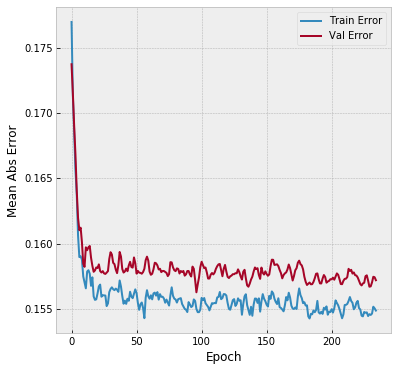

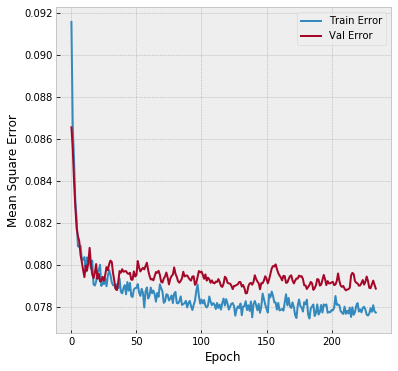

loss: 1.673, acc: 0.155 vloss: 0.077, vacc: 0.330


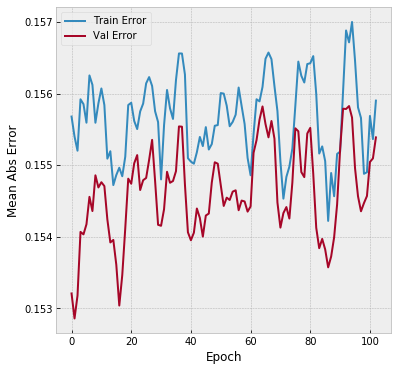

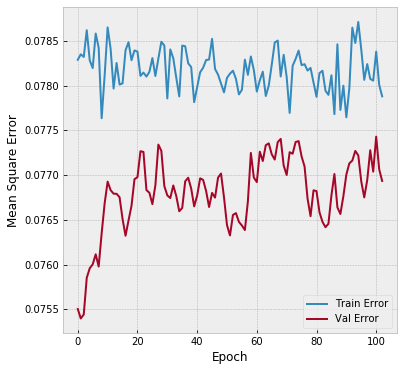

loss: 1.690, acc: 0.155 vloss: 0.078, vacc: 0.316


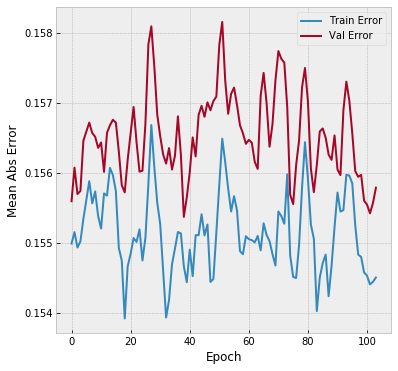

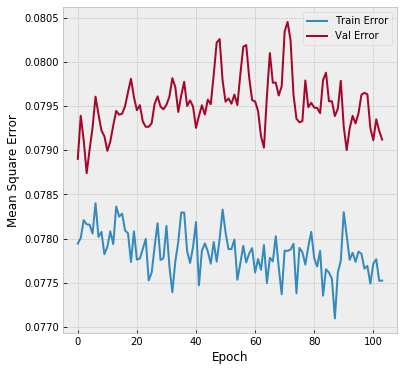

loss: 1.676, acc: 0.154 vloss: 0.077, vacc: 0.321


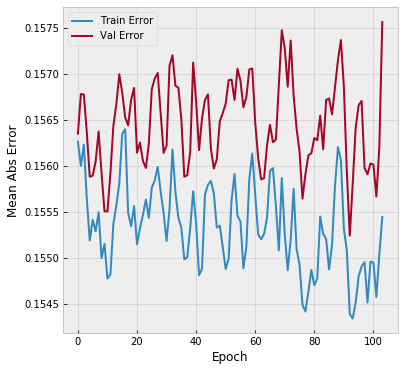

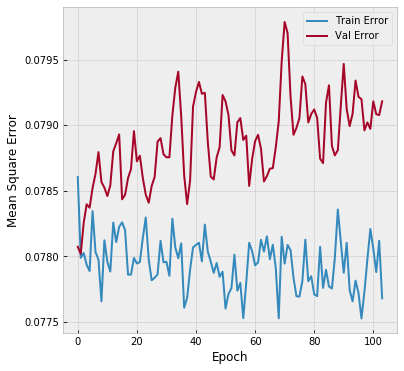

loss: 1.685, acc: 0.155 vloss: 0.077, vacc: 0.317


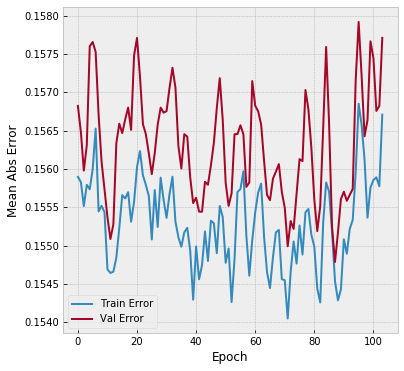

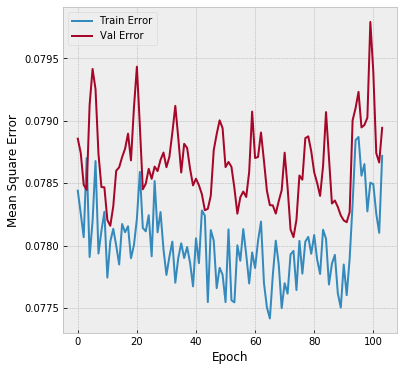

loss: 1.676, acc: 0.155 vloss: 0.077, vacc: 0.318


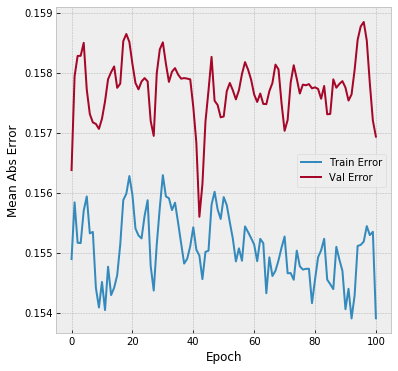

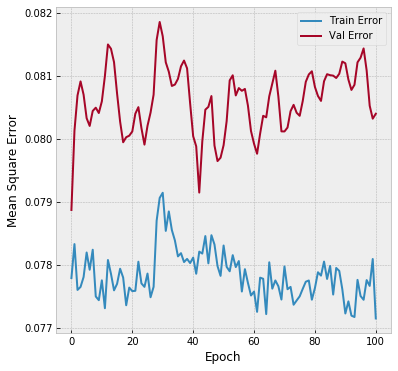

loss: 1.684, acc: 0.154 vloss: 0.077, vacc: 0.319


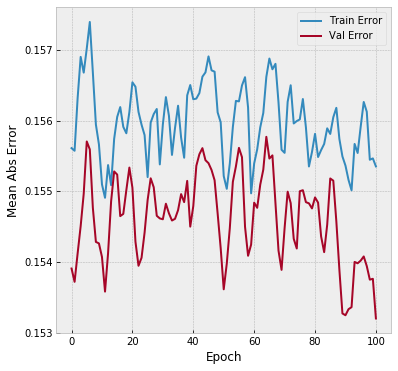

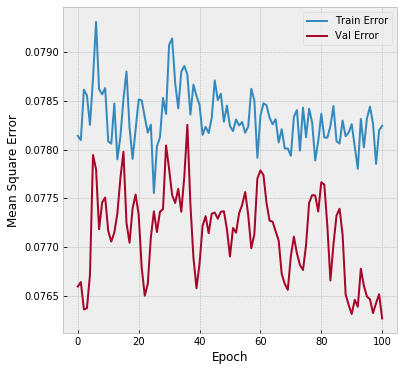

loss: 1.691, acc: 0.155 vloss: 0.078, vacc: 0.321


KeyboardInterrupt: ignored

In [302]:
##### 0D model #####
tf.keras.backend.clear_session()

EPOCHS = 500
BS = 256
WINDOW = 0
FOLDS = 10
FEATURES_NUM = X.shape[1]
FIRE_TYPE_NUM = y.shape[1]

'''
with open( 'values.txt', 'w') as infile:
  infile.write(f'{center} {scale}')
  infile.close()
'''

model = get_model(FEATURES_NUM, FIRE_TYPE_NUM)
callbacks = get_callbacks()

#folds = list(skl.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=RS).split(X, y))
folds = list(skl.model_selection.KFold(n_splits=FOLDS, shuffle=True, random_state=RS).split(X, y))
for j, (train_idx, val_idx) in enumerate(folds):

  tr_data, cv_data = X.iloc[train_idx], X.iloc[val_idx]
  y_trn, y_cv = y.iloc[train_idx], y.iloc[val_idx]

  center, scale = tr_data.mean().values, tr_data.std().values
  trn = (tr_data.values - center)/scale
  cvn = (cv_data.values - center)/scale
  
  model.reset_states()
  history = model.fit(trn, y_trn.values,
            epochs=EPOCHS,
            batch_size=BS,
            shuffle=True,
            use_multiprocessing=True,
            verbose=0,
            validation_data=(cvn, y_cv.values),
            callbacks=callbacks)
  model = tf.keras.models.load_model('my_checkpoint.h5')

  plot_history(history)

  score = model.evaluate(trn, y_trn.values, 
                          batch_size=BS, 
                          verbose=0,
                          use_multiprocessing=True)
  print('loss: {:.3f}, acc: {:.3f} vloss: {:.3f}, vacc: {:.3f}'.format(*score))

#model = tf.keras.models.load_model('my_checkpoint.h5')
model.reset_states()

In [289]:
tr_data, cv_data, y_trn, y_cv = train_test_split(X, y, test_size=0.25, random_state=RS)

trn = (tr_data.values - center)/scale
cvn = (cv_data.values - center)/scale

tr_preds = pd.DataFrame(model.predict(trn, use_multiprocessing=True), index=y_trn.index, columns=y_trn.columns)
cv_preds = pd.DataFrame(model.predict(cvn, use_multiprocessing=True), index=y_cv.index, columns=y_cv.columns)

score = model.evaluate(trn, y_trn.values, 
                         batch_size=BS, 
                         verbose=0,
                         use_multiprocessing=True)
print('loss: {:.3f}, acc: {:.3f} vloss: {:.3f}, vacc: {:.3f}'.format(*score))

auc_trn = skl.metrics.roc_auc_score(y_trn, tr_preds)
auc_cv = skl.metrics.roc_auc_score(y_cv, cv_preds)
print('tr: ROC AUC=%.3f' % (auc_trn))
print('cv: ROC AUC=%.3f' % (auc_cv))

loss: 1.688, acc: 0.154 vloss: 0.077, vacc: 0.337
tr: ROC AUC=0.739
cv: ROC AUC=0.732


Text(0.5, 1, 'Fire Type Counts in cv')

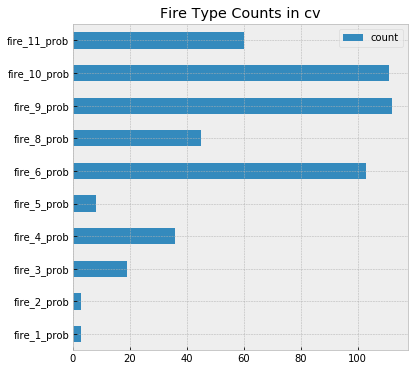

In [290]:
#df_features[TARGET].groupby(df_features[TARGET]).count() , index=

vals = [ y_cv.iloc[:,i].sum() for i in range(y_cv.shape[1]) ]
pd.DataFrame(vals, index=y_cv.columns, columns=['count']).plot.barh();
plt.title('Fire Type Counts in cv', y=1)

In [293]:
#auc_cv = skl.metrics.roc_auc_score(y_cv, cv_preds)
print( cv_preds.iloc[0].sum() )
a = tr_preds.apply(lambda row: row.map(lambda e: 1 if e == row.max() else 0), axis = 1)
a, y_cv

1.0


(         fire_1_prob  fire_2_prob  ...  fire_10_prob  fire_11_prob
 fire_id                            ...                            
 138567             0            0  ...             1             0
 142911             0            0  ...             1             0
 155147             0            0  ...             0             0
 153210             0            0  ...             0             0
 147445             0            0  ...             1             0
 ...              ...          ...  ...           ...           ...
 145579             0            0  ...             0             0
 146406             0            0  ...             1             0
 147343             0            0  ...             0             0
 140644             0            0  ...             0             0
 149812             0            0  ...             0             0
 
 [1500 rows x 10 columns],
          fire_1_prob  fire_2_prob  ...  fire_10_prob  fire_11_prob
 fire_id           

In [0]:
all_pred = pd.DataFrame(model.predict(trn, use_multiprocessing=True), index=y_trn.index, columns=y_trn.columns)

draw_confusion_matrix( all_pred, y_trn)

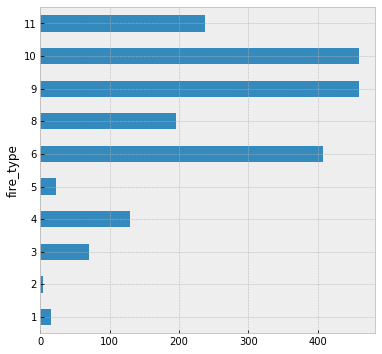

In [254]:
df_features[TARGET].groupby(df_features[TARGET]).count().plot.barh()

Test loss: 1.6663
Test accuracy: 0.1546


Text(0, 0.5, 'predicted activity')

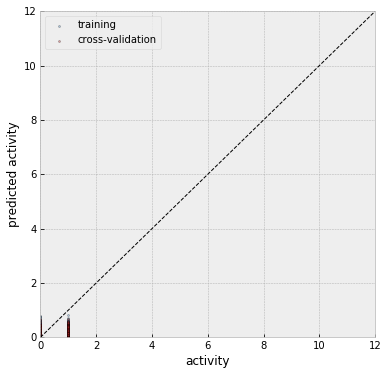

In [225]:
score = model.evaluate(trn, y_trn.values, verbose=0)
print('Test loss: {:.4f}'.format(score[0]))
print('Test accuracy: {:.4f}'.format(score[1]))

plt.scatter(y_trn.values, tr_preds, s=4, alpha=0.4, edgecolor="k", c="steelblue", label="training")
plt.scatter(y_cv.values, cv_preds, s=4, alpha=0.4, edgecolor="k", c="firebrick", label="cross-validation")

plt.xlim(0, 12)
plt.ylim(0, 12)
plt.legend(loc=0)
plt.plot([0, 12], [0, 12], "--", c="k", linewidth=1)
plt.xlabel("activity")
plt.ylabel("predicted activity")

In [226]:
for i in range(5):
  ind = np.int( np.random.random_sample() * tr_preds.shape[0] )
  print( tr_preds.iloc[ind].argmax(), y.iloc[ind].argmax() )

fire_10_prob fire_9_prob
fire_8_prob fire_9_prob
fire_9_prob fire_10_prob
fire_6_prob fire_10_prob
fire_10_prob fire_4_prob


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


## Решение для отправки в систему

In [0]:
import pickle

with open('solution/model.pickle', 'wb') as fout:
    pickle.dump(model, fout, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
df_predictions.to_csv('sample_predictions.csv', index_label='fire_id')